In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from Common_codes import correlation_functions_file_20_3_25 as cff
# from Common_codes import evolution_video_creator as evc
from Common_codes import generic_codes_20_3_25 as gc    
from Common_codes import class_defn_file_20_3_25 as cdf
# from Common_codes import evolution_video_creator as evc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from Common_codes import hamiltonian_derivative_matrices_20_3_25 as hdm

In [9]:
def function_to_create_1D_video(data:np.ndarray,filename,time_data=None)->None:

    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    line, = ax.plot(data[0, :])

    # Step 2: Define the update function for each frame
    def update(frame):
        line.set_ydata(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")
            
        ax.set_ylim(min(data[frame, :]), max(data[frame, :]))
        return line,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10)  
    return    
  
def function_to_create_2D_video(data,square_size:int,filename,time_data=None)->None:
    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    mesh = ax.pcolormesh(np.reshape(data[0, :],(square_size,square_size)), shading='auto', cmap='viridis')

    norm = Normalize(vmin=np.min(data[0,:]), vmax=np.max(data[0,:]))
    # Add a color bar to show the data range
    cbar = plt.colorbar(mesh, ax=ax, norm = norm)

    # Step 2: Define the update function for each frame
    def update(frame):
        mesh.set_array(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")

        norm = Normalize(vmin=np.min(data[frame,:]), vmax=np.max(data[frame,:]))
        mesh.set_norm(norm)
        cbar.update_normal(mesh)
        return mesh,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10) 
    return       

def function_to_extract_SC_order_parameter_complete(delta_r_complete:np.ndarray,Gamma_b_complete:np.ndarray,Gamma_m_complete:np.ndarray,
                                                    lmbda_complete:np.ndarray,
                                                initial_input_variables:cdf.input_variables):
    
    N_b = initial_input_variables.N_b
    N_f = initial_input_variables.N_f
    N_f_spinless = int(N_f/2)
    fourier_transform_matrix = initial_input_variables.fourier_array
    sc_order_parameter_fourier_space_complete = np.zeros((Gamma_m_complete.shape[0],N_b),dtype=np.complex128)

    for time in range(Gamma_m_complete.shape[0]):
        Gamma_m = torch.tensor(np.reshape(Gamma_m_complete[time,:],(2*N_f,2*N_f)),dtype=torch.complex128)
        Gamma_b = torch.tensor(np.reshape(Gamma_b_complete[time,:],(2*N_b,2*N_b)),dtype=torch.complex128)
        delta_r = torch.tensor(np.reshape(delta_r_complete[time,:],(2*N_b,)),dtype=torch.complex128)
        lmbda = torch.tensor(np.reshape(lmbda_complete[time,:],(N_b,N_f)),dtype=torch.complex128)


        initial_input_variables.updating_lambda(lmbda) 

        # Creating the computed variables instance
        computed_variables_instance = cdf.computed_variables(N_b,N_f)

        # Computing the values for the computed_varaibles class
        computed_variables_instance.initialize_all_variables(initial_input_variables,delta_r,Gamma_b)

        fermionic_correlations = cff.correlation_functions(Gamma_m,N_f)

        sc_order_parameter_real_space = hdm.Delta_for_h_m(delta_r = delta_r,Gamma_b=Gamma_b, Gamma_m=Gamma_m,input_variables = initial_input_variables,
                                                        computed_variables= computed_variables_instance,correlation_matrices=fermionic_correlations)

        sc_order_parameter_fouier_space = 1/N_b*torch.einsum('kn,km,nm -> k',fourier_transform_matrix[:,0:N_f_spinless],torch.conj(fourier_transform_matrix[:,0:N_f_spinless]),sc_order_parameter_real_space[0:N_f_spinless,N_f_spinless:])
        # print(sc_order_parameter_fouier_space.shape)
        sc_order_parameter_fourier_space_complete[time,:] = np.array(sc_order_parameter_fouier_space)
    return sc_order_parameter_fourier_space_complete

def function_to_extract_c_dagger_c_data_complete(Gamma_m_complete:np.ndarray,N_f):
    
    c_dagger_c_data_complete = np.zeros((Gamma_m_complete.shape[0],N_f*N_f),dtype=np.complex128)
    
    for time in range(Gamma_m_complete.shape[0]):
        Gamma_m = torch.tensor(np.reshape(Gamma_m_complete[time,:],(2*N_f,2*N_f)),dtype=torch.complex128)

        fermionic_correlations = cff.correlation_functions(Gamma_m,N_f)

        c_dagger_c_data_complete[time,:] = np.array(fermionic_correlations.c_dagger_c_mat).flatten()
    
    return c_dagger_c_data_complete

def function_to_extract_c_c_data_complete(Gamma_m_complete:np.ndarray,N_f):
    
    c_dagger_c_data_complete = np.zeros((Gamma_m_complete.shape[0],N_f*N_f),dtype=np.complex128)
    
    for time in range(Gamma_m_complete.shape[0]):
        Gamma_m = torch.tensor(np.reshape(Gamma_m_complete[time,:],(2*N_f,2*N_f)),dtype=torch.complex128)

        fermionic_correlations = cff.correlation_functions(Gamma_m,N_f)

        c_dagger_c_data_complete[time,:] = np.array(fermionic_correlations.c_c_mat).flatten()
    
    return c_dagger_c_data_complete

def function_to_create_2D_video_colorbar_fixed(data,square_size:int,filename,time_data=None)->None:
    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    mesh = ax.pcolormesh(np.reshape(data[0, :],(square_size,square_size)), shading='auto', cmap='viridis',
                         vmin=np.min(data[0,:]), vmax=np.max(data[0,:]))

    # Add a color bar to show the data range
    cbar = plt.colorbar(mesh, ax=ax)

    # Step 2: Define the update function for each frame
    def update(frame):
        mesh.set_array(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")
        return mesh,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10) 
    return       


In [ ]:
###########################################################
###########################################################
# from Common_codes.class_defn_file_20_3_25 import input_variables


number_of_points = 10
positon_value_max = [10 , 10]
positon_value_min = [0  , 0]
position_space_grid = gc.coordinate_array_creator_function(positon_value_min,positon_value_max,number_of_points,True)
position_space_grid_tensor = torch.tensor(position_space_grid)

N_f = np.shape(position_space_grid)[0]
print("Position space grid created")

momentum_value_max = [np.pi/(positon_value_max[0]-positon_value_min[0])*number_of_points ,np.pi/(positon_value_max[1]-positon_value_min[1])*number_of_points]
momentum_value_min = [-np.pi/(positon_value_max[0]-positon_value_min[0])*number_of_points ,-np.pi/(positon_value_max[1]-positon_value_min[1])*number_of_points]
momentum_space_grid = gc.coordinate_array_creator_function(momentum_value_min,momentum_value_max,number_of_points,False)
momentum_space_grid_tensor = torch.tensor(momentum_space_grid)

N_b = np.shape(momentum_space_grid)[0]
print("Momentum space grid created")

boson_space_grid = gc.coordinate_array_creator_function(positon_value_min,positon_value_max,number_of_points,False)
boson_space_grid_tensor = torch.tensor(boson_space_grid)
fourier_transform_matrix = torch.tensor(gc.creating_fourier_matrix(momentum_space_grid,position_space_grid))

volume = np.prod(np.array(positon_value_max)-np.array(positon_value_min))

###########################################################
###########################################################

momentum_space_mesh = np.meshgrid(np.linspace(momentum_value_min[0],momentum_value_max[0],number_of_points,endpoint=False),np.linspace(momentum_value_min[1],momentum_value_max[1],number_of_points,endpoint=False))


###########################################################
###########################################################

J_0 = -1
J_0_matrix = gc.creating_J_0_matrix(position_space_grid,J_0,positon_value_max[0],spin_index=True)
J_0_tensor = torch.tensor(J_0_matrix,dtype=torch.complex128)

# print(" J_0 matrix created")
# plt.pcolormesh(J_0_matrix)
# plt.title("J_0 matrix")
# plt.colorbar()
# plt.show()

# J_0_matrix = np.diag(np.ones(N_f)*J_0,1) + np.diag(np.ones(N_f)*J_0,-1)
omega_0 = 10*np.abs(J_0)
omega = 10*np.abs(J_0)*np.identity(N_b)
omega_tensor = torch.tensor(omega,dtype=torch.complex128)

# print("omega matrix created")

gamma_0 = 0.5*omega_0
gamma = gamma_0*np.append(np.identity(N_b),np.identity(N_b),axis = 1)
gamma_tensor = torch.tensor(gamma,dtype=torch.complex128)

chemical_potential_val = -5.1
###########################################################
###########################################################
# delta_r_complete = np.load("real_time_evo_delta_r_complete_mu_ini_-5.5_mu_final_-5.1_t_50.npy")
delta_r_complete = np.load("real_time_evo_delta_r_complete_mu_ini_-5.1_mu_final_-5.5_t_40.npy")
print("delta_r complete data extracted")

# gamma_b_complete = np.load("real_time_evo_gamma_b_complete_mu_ini_-5.5_mu_final_-5.1_t_50.npy")
gamma_b_complete = np.load("real_time_evo_gamma_b_complete_mu_ini_-5.1_mu_final_-5.5_t_40.npy")
print("gamma_b complete data extracted")

# gamma_m_complete = np.load("real_time_evo_gamma_m_complete_mu_ini_-5.5_mu_final_-5.1_t_50.npy")
gamma_m_complete = np.load("real_time_evo_gamma_m_complete_mu_ini_-5.1_mu_final_-5.5_t_40.npy")
print("gamma_m complete data extracted")

# lmbda_complete = np.load("real_time_evo_lambda_complete_mu_ini_-5.5_mu_final_-5.1_t_50.npy")
lmbda_complete = np.load("real_time_evo_lambda_complete_mu_ini_-5.1_mu_final_-5.5_t_40.npy")
print("lambda complete data extracted")
###########################################################
###########################################################
lmbda_initial = torch.tensor(np.reshape(lmbda_complete[0,:],(N_b,N_f)),dtype=torch.complex128)
initial_input_variables = cdf.input_variables(position_space_grid_tensor,boson_space_grid_tensor,fourier_transform_matrix,lmbda_initial,J_0_tensor,gamma_tensor,omega_tensor,chemical_potential_val)
# initial_input_variables.updating_lambda_bar_from_lambda(lmbda_q=lmbda,volume=N_b)  # Note that here we need to change the volume if we ever do. Else, it is N_b.

# initial_input_variables.updating_lambda(lmbda_initial)
print("Initial input variables class created")
###########################################################
###########################################################

# Extracting the c dagger c data
c_dagger_c_data_complete = function_to_extract_c_dagger_c_data_complete(gamma_m_complete,initial_input_variables.N_f)
print("c_dagger c data extracted")

# Extracting the Superconductor order parameter

sc_order_parameter_fourier_space_complete = function_to_extract_SC_order_parameter_complete(delta_r_complete,gamma_b_complete,gamma_m_complete,
                                                lmbda_complete,initial_input_variables)
print("SC order parameter (fourier space) extracted")
###########################################################
###########################################################
print("All matrices created and computed")

Position space grid created
Momentum space grid created
delta_r complete data extracted
gamma_b complete data extracted
gamma_m complete data extracted
lambda complete data extracted
Initial input variables class created


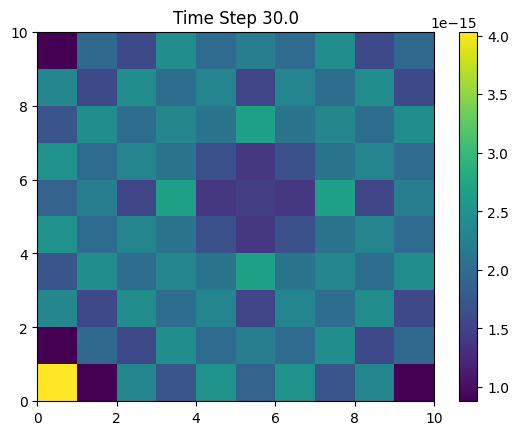

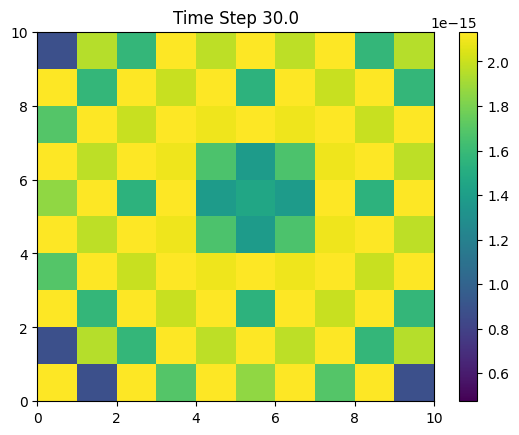

In [ ]:
# Plotting the sc order parameter

time_data = np.load("time_data.npy")+20
function_to_create_2D_video(np.abs(sc_order_parameter_fourier_space_complete), 10, "sc_order_parameter_fourier_space_complete_mu_ini_-5.1_mu_final_-5._t_40",time_data)
function_to_create_2D_video_colorbar_fixed(np.abs(sc_order_parameter_fourier_space_complete), 10, "sc_order_parameter_fourier_space_cbar_fixed_complete_mu_ini_-5.1_mu_final_-5.5_t_40",time_data)

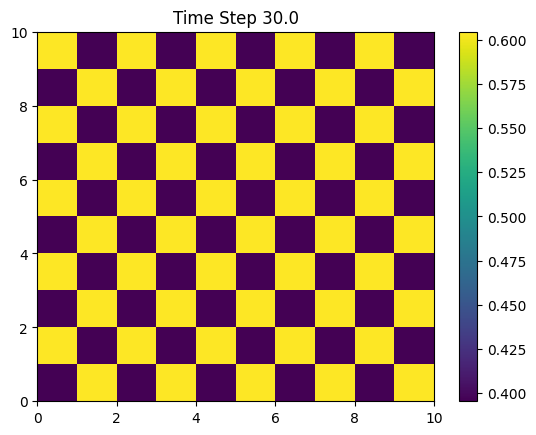

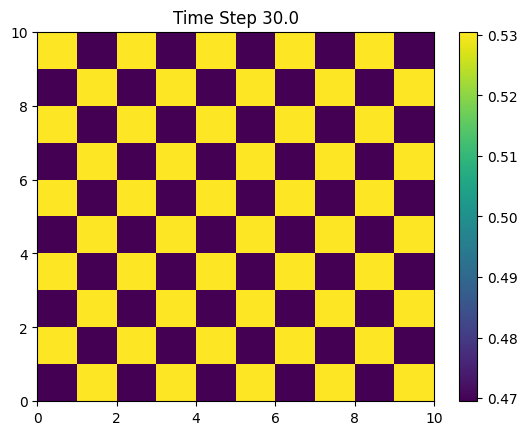

In [ ]:
# Extracting and plotting the CDW order parameter order parameter

time_data = np.load("time_data.npy")+20

def extracting_diagonal_c_dagger_c(c_dagger_c_data_complete,N_f):
    N_f_spinless = int(N_f/2) 
    diagonal_data = np.zeros((c_dagger_c_data_complete.shape[0], N_f_spinless), dtype=np.float64)
    for time in range(c_dagger_c_data_complete.shape[0]):
        diagonal_data[time, :] = np.diag(np.reshape(c_dagger_c_data_complete[time, :], (N_f, N_f))[0:N_f_spinless,0:N_f_spinless]).real
    return diagonal_data

diagonal_data = extracting_diagonal_c_dagger_c(c_dagger_c_data_complete,initial_input_variables.N_f)
function_to_create_2D_video(diagonal_data, 10, "CDW_order_mu_ini_-5.1_mu_final_-5.5_t_40",time_data)
function_to_create_2D_video_colorbar_fixed(diagonal_data, 10, "CDW_order_mu_cbar_fixed_mu_ini_-5.1_mu_final_-5.5_t_40",time_data)


In [ ]:

# function_to_create_2D_video_colorbar_fixed(diagonal_data, 10, "c_dagger_c_colorbar_fixed_mu_ini_-5.5_mu_final_-5.1_t_50",time_data)

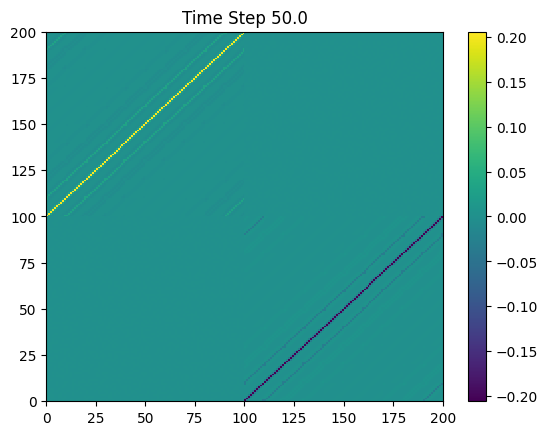

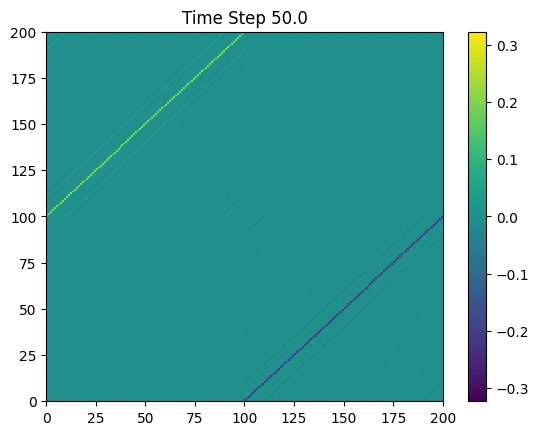

In [83]:
time_data = np.load("time_data.npy")

def extracting_diagonal_c_c(c_dagger_c_data_complete,N_f):
    N_f_spinless = int(N_f/2) 
    diagonal_data = np.zeros((c_dagger_c_data_complete.shape[0], N_f_spinless), dtype=np.float64)
    for time in range(c_dagger_c_data_complete.shape[0]):
        diagonal_data[time, :] = np.diag(np.reshape(c_dagger_c_data_complete[time, :], (N_f, N_f))[0:N_f_spinless,N_f_spinless:]).real
    return diagonal_data

c_c_data_complete = function_to_extract_c_c_data_complete(gamma_m_complete,initial_input_variables.N_f)

# diagonal_data = extracting_diagonal_c_c(c_c_data_complete,initial_input_variables.N_f)
function_to_create_2D_video(c_c_data_complete.real, 200, "c_c_complete_mu_ini_-5.5_mu_final_-5.1_t_50",time_data)
function_to_create_2D_video_colorbar_fixed(c_c_data_complete.real, 200, "c_c_complete_cbar_fixed_mu_ini_-5.5_mu_final_-5.1_t_50",time_data)


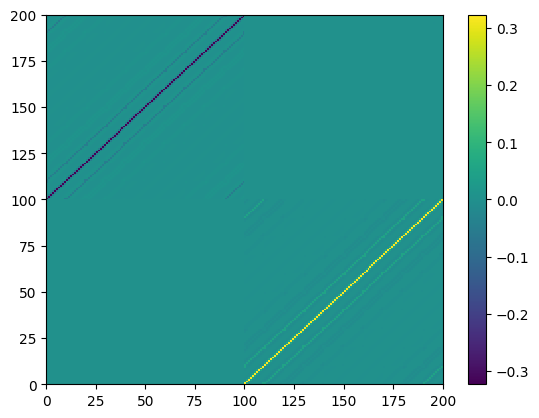

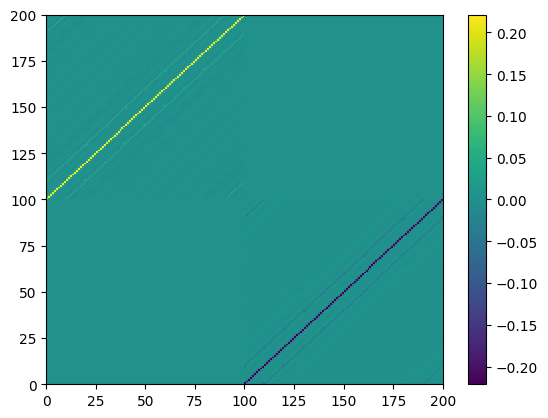

In [80]:
plt.pcolormesh(np.reshape(c_c_data_complete[0,:],(200,200)).real)
plt.colorbar()
plt.show()

plt.pcolormesh(np.reshape(c_c_data_complete[10,:],(200,200)).real)
plt.colorbar()
plt.show()


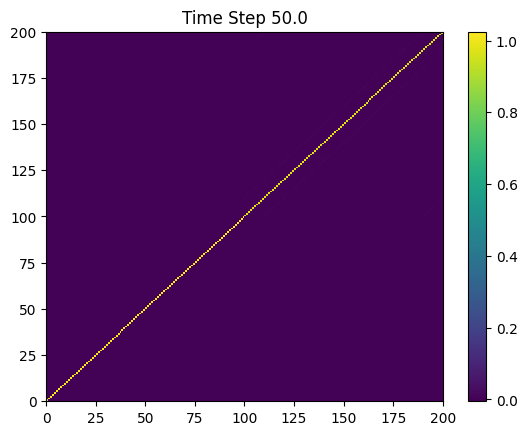

In [ ]:
gamma_b_complete = np.load("real_time_evo_gamma_b_complete_mu_ini_-5.5_mu_final_-5.1_t_50.npy")
function_to_create_2D_video(gamma_b_complete, 200, "gamma_b_complete_mu_ini_-5.5_mu_final_-5.1_t_50",time_data)


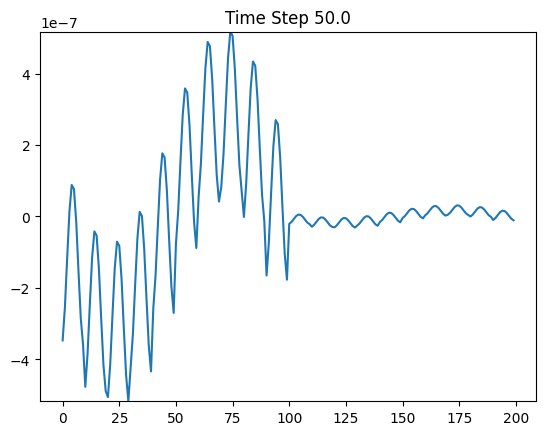

In [22]:
delta_r_complete = np.load("real_time_evo_delta_r_complete_mu_ini_-5.5_mu_final_-5.1_t_50.npy")
function_to_create_1D_video(delta_r_complete, "delta_r_complete_mu_ini_-5.5_mu_final_-5.1_t_50",time_data)

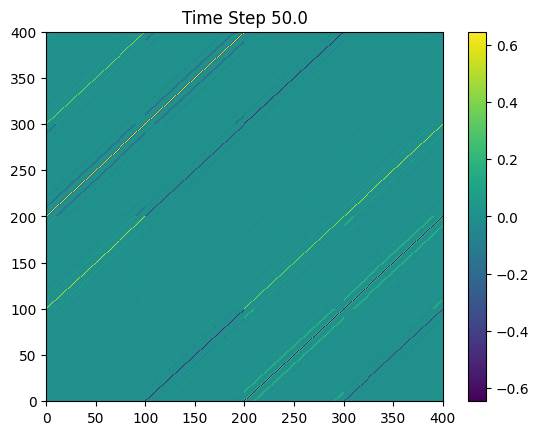

In [67]:
gamma_m_complete = np.load("real_time_evo_gamma_m_complete_mu_ini_-5.5_mu_final_-5.1_t_50.npy")
# function_to_create_2D_video(gamma_m_complete, 400, "gamma_m_complete_mu_ini_-5.5_mu_final_-5.1_t_50",time_data)
function_to_create_2D_video_colorbar_fixed(gamma_m_complete, 400, "gamma_m_complete_cbar_fixed_mu_ini_-5.5_mu_final_-5.1_t_50",time_data)

In [32]:
np.reshape(lmbda_complete[0,:],(N_b,N_f))

array([[ 4.49883837e-01,  1.07069854e-02,  5.21339155e-04, ...,
         2.14732983e-05,  1.91012584e-04,  8.16301294e-04],
       [ 1.07177783e-02,  4.49894630e-01,  1.07177783e-02, ...,
        -9.34256028e-07,  1.06804461e-05,  1.80219732e-04],
       [ 5.34858956e-04,  1.07205052e-02,  4.49897357e-01, ...,
        -4.74837180e-06, -3.66120487e-06,  7.95349719e-06],
       ...,
       [ 1.07009376e-05, -9.13764576e-07, -2.00093146e-06, ...,
         4.49894609e-01,  1.07177578e-02,  5.32111516e-04],
       [ 1.82309355e-04,  1.27700688e-05,  1.15536665e-06, ...,
         1.07156887e-02,  4.49892540e-01,  1.07156887e-02],
       [ 8.07863070e-04,  1.82574361e-04,  1.30350749e-05, ...,
         5.29777378e-04,  1.07154237e-02,  4.49892275e-01]])